#  Generate data

In [1]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

m = bi(platform='cpu')

jax.local_device_count 16


# DPMM

In [2]:

data, true_labels = make_blobs(
    n_samples=500, centers=8, cluster_std=0.8,
    center_box=(-10,10), random_state=101
)
N, D = data.shape
T=10
from sklearn.cluster import KMeans
from numpyro.infer import init_to_value
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto')
kmeans.fit(data)
initial_means = kmeans.cluster_centers_
if initial_means.shape[0] < T:
    padding = jnp.zeros((T - initial_means.shape[0], data.shape[1]))
    initial_means = jnp.concatenate([initial_means, padding], axis=0)


/home/sosa/work/BI/BI/Main/main.py:198: FutureWarning: Some algorithms will automatically enumerate the discrete latent site z of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  self.sampler.run(jax.random.PRNGKey(seed), **self.data_on_model)
sample: 100%|██████████| 1000/1000 [00:28<00:00, 35.46it/s, 63 steps of size 8.11e-02. acc. prob=0.81] 


Model found 8 clusters.


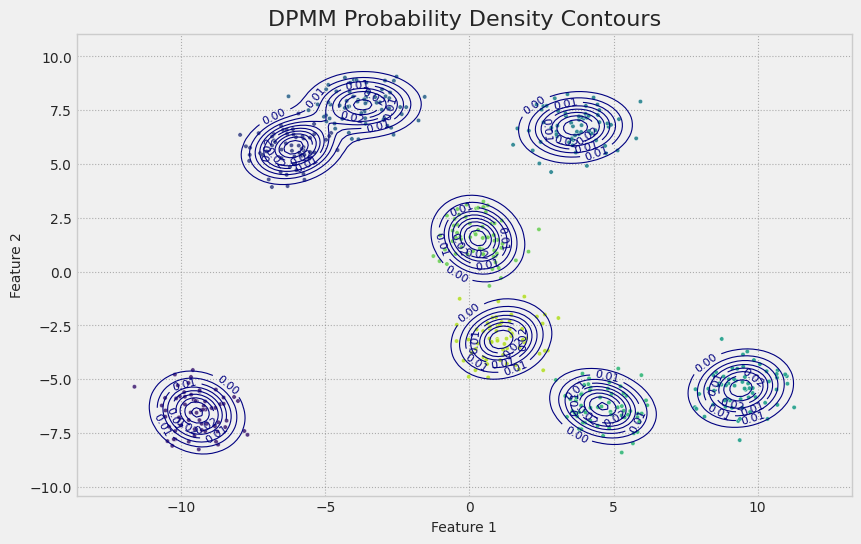

In [3]:
m.data_on_model = dict(data=data,T=10)
m.fit(m.models.dpmm)
m.plot(data,m.sampler)

# GMM

In [ ]:

m.data_on_model = {
    "data": data,
    "K": 4 # You must pass the number of clusters you want to find
}
m.ml.KMEANS(m.data_on_model['data'], n_clusters=m.data_on_model['K'])

m.fit(m.gmm)
m.plot(X=data,sampler=m.sampler)

NameError: name 'data' is not defined

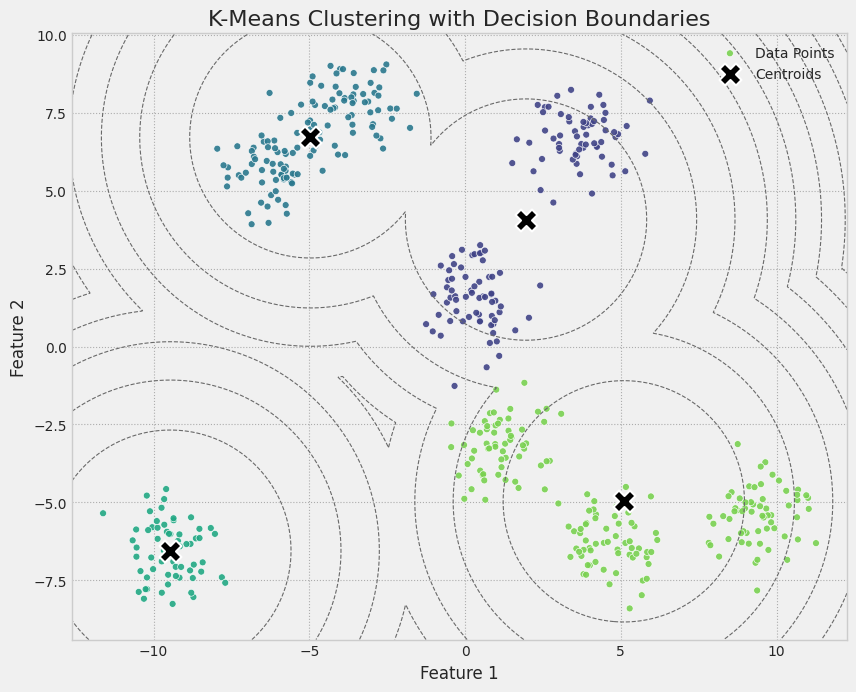

In [6]:

m.ml.KMEANS(
        data,
        n_clusters=4,
        n_iterations=150,
        random_state=42
    ).predict(data)
m.ml.plot(data)